In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/gggsdsd/balanced.csv',encoding='utf-8')
df.head()

,texts,label
0,अमेरिकी और रूसी पुलिस के संयुक्त अभियान के फलस...,0
1,आज यहां रांची एक्सप्रेस के साथ बातचीत में वित्...,0
2,हमे इन्तजार है ।,1
3,जिस के नतीजे मे ये हुक्म सादिर किया गया है ।,1
4,जयपुर,0


In [ ]:
df = df[df['texts'].apply(lambda x: isinstance(x, str))]

In [ ]:
import pandas as pd
import re

# Define sets of characters for different linguistic categories
vowels = set('\u0904\u0905\u0906\u0907\u0908\u0909\u090A\u090B\u090C\u090D\u090E\u090F\u0910\u0911\u0912\u0913\u0914')
consonants = set('\u0915\u0916\u0917\u0918\u0919\u091A\u091B\u091C\u091D\u091E\u091F\u0920\u0921\u0922\u0923\u0924\u0925\u0926\u0927\u0928\u092A\u092B\u092C\u092D\u092E\u092F\u0930\u0932\u0933\u0935\u0936\u0937\u0938\u0939')
matras = set('\u093A\u093B\u093C\u093D\u093E\u093F\u0940\u0941\u0942\u0943\u0944\u0945\u0946\u0947\u0948\u0949\u094A\u094B\u094C')
nukta = '\u093C'
virama = '\u094D'
anusvara = '\u0902'
visarga = '\u0903'

def count_linguistic_features(word):
    akshara_count = 0
    matra_count = 0
    phoneme_count = 0
    syllable_count = 0

    i = 0
    while i < len(word):
        char = word[i]

        if char in vowels:
            phoneme_count += 1
            syllable_count += 1
            akshara_count += 1
        elif char in consonants:
            akshara_count += 1
            phoneme_count += 1

            # Check for conjuncts
            if i + 1 < len(word) and word[i+1] == virama:
                i += 1  # Skip the virama
                if i + 1 < len(word) and word[i+1] in consonants:
                    i += 1  # Move to the next consonant
                    phoneme_count += 1  # Count the conjunct as one additional phoneme
            else:
                syllable_count += 1

            # Check for following matra
            if i + 1 < len(word) and word[i+1] in matras:
                i += 1
                matra_count += 1
                phoneme_count += 1
        elif char in matras:
            matra_count += 1
            phoneme_count += 1
            syllable_count += 1
        elif char == anusvara or char == visarga:
            phoneme_count += 1
        elif char == nukta:
            # Nukta modifies the previous consonant, doesn't add a new phoneme
            pass

        i += 1

    return akshara_count, matra_count, phoneme_count, syllable_count

def average_linguistic_features_per_word(sentence):
    if pd.isna(sentence) or not isinstance(sentence, str):
        return 0, 0, 0, 0, 0
    words = sentence.split()
    if not words:
        return 0, 0, 0, 0, 0

    total_aksharas = 0
    total_matras = 0
    total_phonemes = 0
    total_syllables = 0

    for word in words:
        aksharas, matras, phonemes, syllables = count_linguistic_features(word)
        total_aksharas += aksharas
        total_matras += matras
        total_phonemes += phonemes
        total_syllables += syllables

    word_count = len(words)
    avg_aksharas = total_aksharas / word_count
    avg_matras = total_matras / word_count
    avg_phonemes = total_phonemes / word_count
    avg_syllables = total_syllables / word_count

    return avg_aksharas, avg_matras, avg_aksharas + avg_matras, avg_phonemes, avg_syllables

# Apply the function to create all five columns at once
df[['nAksh', 'nMatra', 'AMCount', 'nPhen', 'nSyll']] = df['texts'].apply(lambda x: pd.Series(average_linguistic_features_per_word(x)))

In [ ]:
df.head()

,texts,label,nAksh,nMatra,AMCount,nPhen,nSyll
0,अमेरिकी और रूसी पुलिस के संयुक्त अभियान के फलस...,0,2.481481,1.407407,3.888889,4.185185,2.333333
1,आज यहां रांची एक्सप्रेस के साथ बातचीत में वित्...,0,2.307692,1.230769,3.538462,4.230769,1.923077
2,हमे इन्तजार है ।,1,1.750000,0.750000,2.500000,2.750000,1.500000
3,जिस के नतीजे मे ये हुक्म सादिर किया गया है ।,1,1.636364,1.181818,2.818182,2.909091,1.545455
4,जयपुर,0,4.000000,1.000000,5.000000,5.000000,4.000000


In [ ]:
hindi_word_freq = {
}

In [ ]:
def calculate_awf(sentence):
    if pd.isna(sentence) or not isinstance(sentence, str):
        return 0

    # Remove any non-Hindi characters and split into words
    words = re.findall(r'[\u0900-\u097F]+', sentence)

    if not words:
        return 0

    total_freq = 0
    word_count = 0

    for word in words:
        if word in hindi_word_freq:
            total_freq += hindi_word_freq[word]
            word_count += 1

    # If none of the words were found in our frequency dictionary
    if word_count == 0:
        return 0

    return total_freq / word_count

# Apply the function to create the new 'awf' column
df['awf'] = df['texts'].apply(calculate_awf)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Separate features and target
X = df.drop('label', axis=1)
X = X.drop('texts', axis=1)
y = df['label']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)
y_pred_logistic = logistic_regression.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("\nLogistic Regression Accuracy:", accuracy_logistic)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.8082191780821918

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      3826
           1       0.81      0.81      0.81      3912

    accuracy                           0.81      7738
   macro avg       0.81      0.81      0.81      7738
weighted avg       0.81      0.81      0.81      7738



Feature Importance:
 nPhen      4.990141
nAksh      1.415892
AMCount    1.396879
nMatra     0.970360
nSyll      0.622295
awf        0.000000
dtype: float64


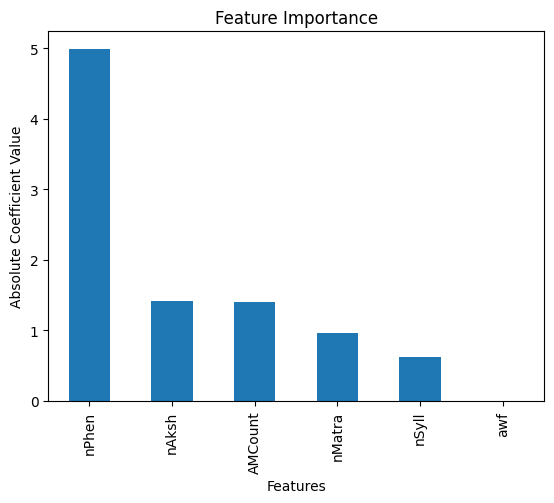

In [ ]:
coefficients = logistic_regression.coef_[0]
feature_importance = pd.Series(coefficients, index=X.columns)

# Get the absolute values of the coefficients to determine importance
feature_importance = np.abs(feature_importance)
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance:\n", feature_importance)

# Optionally, visualize the feature importance
import matplotlib.pyplot as plt
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.show()

In [ ]:
df.to_csv('shabd_features.csv', index=False)